# Radial Basis Function

In [120]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import  r2_score
from sklearn.model_selection import train_test_split
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Random train/test split (200 for test, 500 for training and cross-validation)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_input, Y_train_input, test_size=200, random_state=42, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [122]:
# Hyperparameter grids - Specialized
gamma_list =  [0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
alpha_list = [0.0016, 0.0017, 0.0018, 0.0019, 0.002, 0.0021, 0.0022]

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -np.inf
best_params = None
results = []

In [123]:
for gamma, alpha in product(gamma_list, alpha_list):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        Y_tr, Y_val = Y_train[train_idx], Y_train[val_idx]
    
        # Train Ridge regression
        model = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)
        model.fit(X_tr, Y_tr)
        
        # Predict on validation fold
        Y_val_pred = model.predict(X_val)
        r2_scores.append(r2_score(Y_val, Y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({'gamma': gamma, 'alpha': alpha, 'mean_r2': mean_r2})
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'gamma': gamma, 'alpha': alpha}

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Best Cross Validation R2: 0.9900238588178759
Best Hyperparameters: {'gamma': 0.13, 'alpha': 0.0016}


In [124]:
# Refit model on all 500 training samples using best hyperparameters
gamma_best = best_params['gamma']
alpha_best = best_params['alpha']

# Train final model
final_model = KernelRidge(kernel='rbf', gamma=gamma_best, alpha=alpha_best)
final_model.fit(X_train_scaled, Y_train)

# Predict on held-out 200 samples
Y_test_pred = final_model.predict(X_test_scaled)
test_r2 = r2_score(Y_test, Y_test_pred)
print("R2 on held-out 200 test samples:", test_r2)

R2 on held-out 200 test samples: 0.9853108366731896


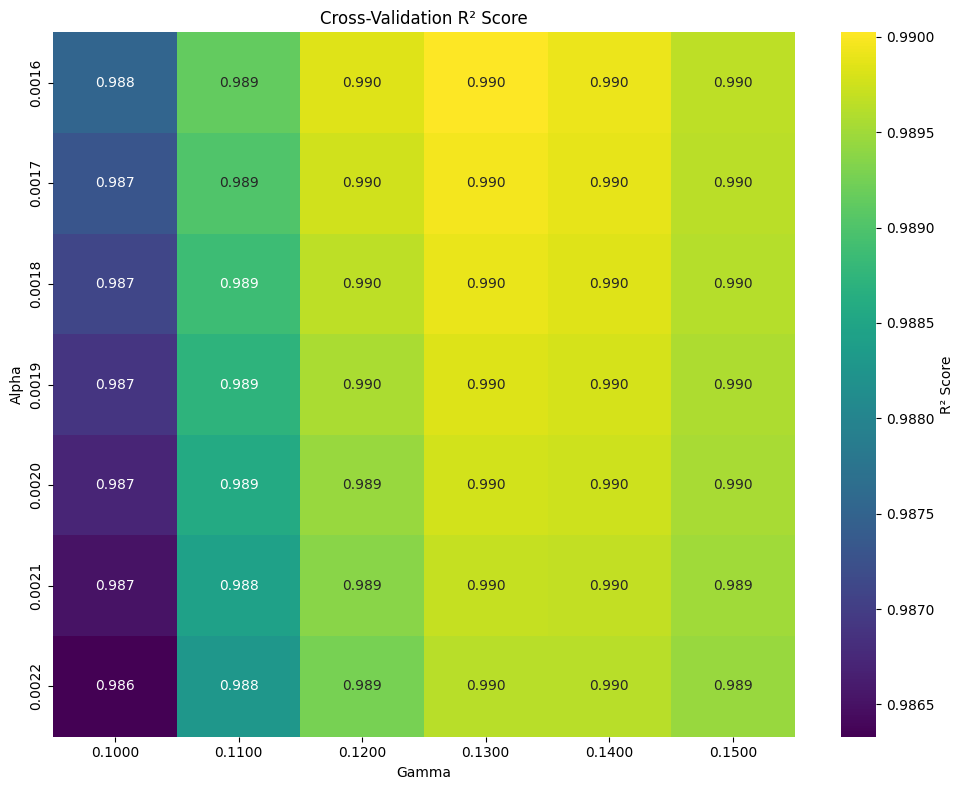

In [125]:
# Convert results to 2D array for heatmap
gamma_vals = sorted(list(set(r['gamma'] for r in results)))
alpha_vals = sorted(list(set(r['alpha'] for r in results)))

# Create heatmap data
heatmap_data = np.zeros((len(alpha_vals), len(gamma_vals)))

for i, alpha in enumerate(alpha_vals):
    for j, gamma in enumerate(gamma_vals):
        # Find corresponding mean_r2
        for r in results:
            if r['gamma'] == gamma and r['alpha'] == alpha:
                heatmap_data[i, j] = r['mean_r2']
                break

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt=".3f", 
            xticklabels=[f"{g:.4f}" for g in gamma_vals],
            yticklabels=[f"{a:.4f}" for a in alpha_vals],
            cmap="viridis",
            cbar_kws={'label': 'R² Score'})
plt.title("Cross-Validation R² Score")
plt.xlabel("Gamma")
plt.ylabel("Alpha")
plt.tight_layout()
plt.show()

Sensor 0: Importance = 0.1487
Sensor 1: Importance = -0.0008
Sensor 2: Importance = 0.4097
Sensor 3: Importance = 0.9023
Sensor 4: Importance = 0.5083
Sensor 5: Importance = 0.5898


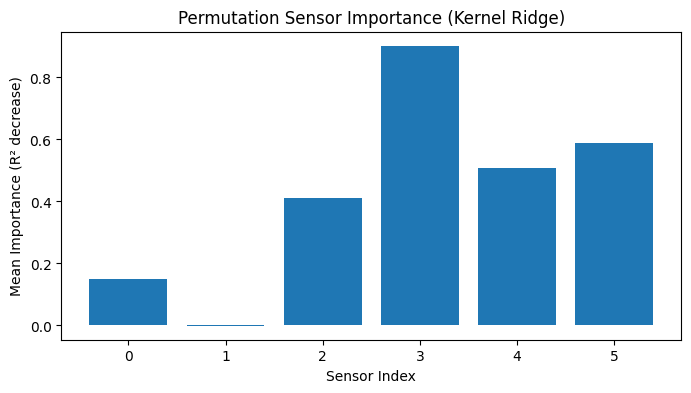

In [126]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on the test set
result = permutation_importance(final_model, X_test_scaled, Y_test, n_repeats=10, random_state=42, scoring='r2')

for i, imp in enumerate(result.importances_mean):
    print(f"Sensor {i}: Importance = {imp:.4f}")

plt.figure(figsize=(8, 4))
plt.bar(range(X_test_scaled.shape[1]), result.importances_mean)
plt.xlabel("Sensor Index")
plt.ylabel("Mean Importance (R² decrease)")
plt.title("Permutation Sensor Importance (Kernel Ridge)")
plt.show()

# Removed the Second Sensor Measurements

In [127]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Remove the second entry (index 1) 
X_train_input = np.delete(X_train_input, 1, axis=1)

print("New shapes:", X_train_input.shape, Y_train_input.shape)

# Random train/test split (200 for test, rest for training)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_input, Y_train_input, test_size=200, random_state=42, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

New shapes: (700, 5) (700,)


In [128]:
# Hyperparameter grids - Specialized
gamma_list =  [0.13, 0.14, 0.15, 0.16, 0.17]
alpha_list = [0.0005, 0.001, 0.002, 0.003]

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -np.inf
best_params = None
results = []

In [129]:
for gamma, alpha in product(gamma_list, alpha_list):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        Y_tr, Y_val = Y_train[train_idx], Y_train[val_idx]
    
        # Train Ridge regression
        model = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)
        model.fit(X_tr, Y_tr)
        
        # Predict on validation fold
        Y_val_pred = model.predict(X_val)
        r2_scores.append(r2_score(Y_val, Y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({'gamma': gamma, 'alpha': alpha, 'mean_r2': mean_r2})
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'gamma': gamma, 'alpha': alpha}

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Best Cross Validation R2: 0.9933042038559551
Best Hyperparameters: {'gamma': 0.14, 'alpha': 0.002}


In [130]:
# Refit model on all 500 training samples using best hyperparameters
gamma_best = best_params['gamma']
alpha_best = best_params['alpha']

# Train final model
final_model = KernelRidge(kernel='rbf', gamma=gamma_best, alpha=alpha_best)
final_model.fit(X_train_scaled, Y_train)

# Predict on held-out 200 samples
Y_test_pred = final_model.predict(X_test_scaled)
test_r2 = r2_score(Y_test, Y_test_pred)
print("R2 on held-out 200 test samples:", test_r2)

R2 on held-out 200 test samples: 0.9915600334455307


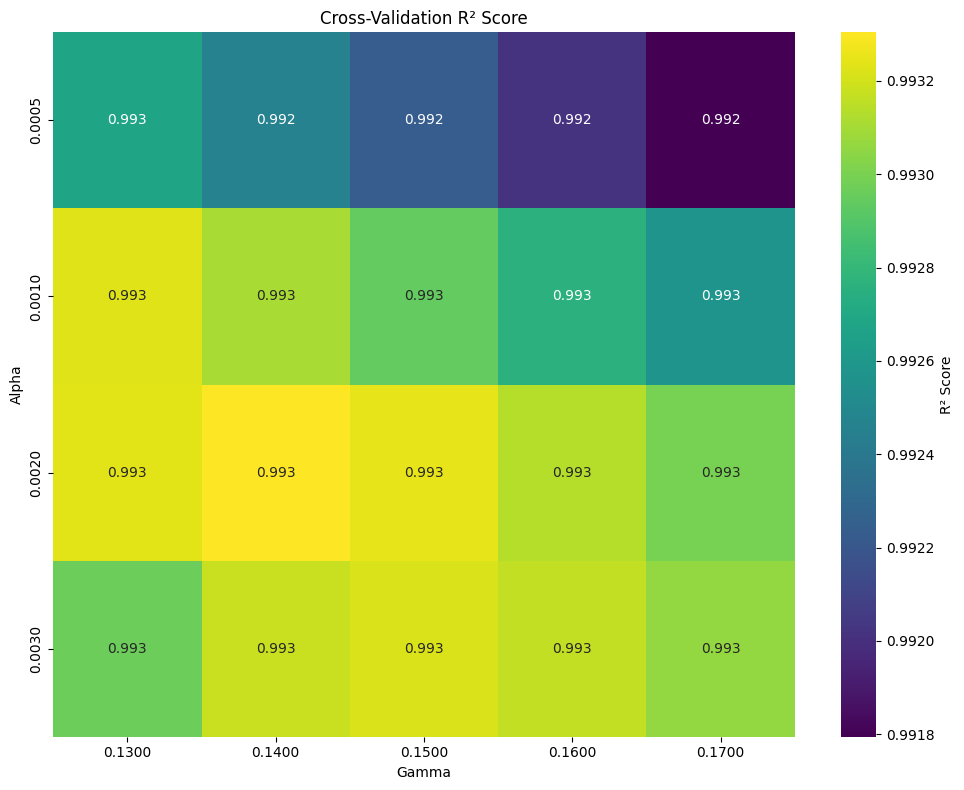

In [131]:
# Convert results to 2D array for heatmap
gamma_vals = sorted(list(set(r['gamma'] for r in results)))
alpha_vals = sorted(list(set(r['alpha'] for r in results)))

# Create heatmap data
heatmap_data = np.zeros((len(alpha_vals), len(gamma_vals)))

for i, alpha in enumerate(alpha_vals):
    for j, gamma in enumerate(gamma_vals):
        # Find corresponding mean_r2
        for r in results:
            if r['gamma'] == gamma and r['alpha'] == alpha:
                heatmap_data[i, j] = r['mean_r2']
                break

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt=".3f", 
            xticklabels=[f"{g:.4f}" for g in gamma_vals],
            yticklabels=[f"{a:.4f}" for a in alpha_vals],
            cmap="viridis",
            cbar_kws={'label': 'R² Score'})
plt.title("Cross-Validation R² Score")
plt.xlabel("Gamma")
plt.ylabel("Alpha")
plt.tight_layout()
plt.show()

# Remove the First and Second Sensors Measurements

In [132]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Remove the second entry (index 1) 
X_train_input = np.delete(X_train_input, [0, 1], axis=1)

print("New shapes:", X_train_input.shape, Y_train_input.shape)

# Random train/test split (200 for test, rest for training)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_input, Y_train_input, test_size=200, random_state=42, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

New shapes: (700, 4) (700,)


In [133]:
# Hyperparameter grids - Specialized
gamma_list =  [0.13, 0.14, 0.15, 0.16, 0.17]
alpha_list = [0.002, 0.003, 0.004, 0.005]

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -np.inf
best_params = None
results = []

In [134]:
for gamma, alpha in product(gamma_list, alpha_list):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        Y_tr, Y_val = Y_train[train_idx], Y_train[val_idx]
    
        # Train Ridge regression
        model = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)
        model.fit(X_tr, Y_tr)
        
        # Predict on validation fold
        Y_val_pred = model.predict(X_val)
        r2_scores.append(r2_score(Y_val, Y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({'gamma': gamma, 'alpha': alpha, 'mean_r2': mean_r2})
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'gamma': gamma, 'alpha': alpha}

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Best Cross Validation R2: 0.990139974349287
Best Hyperparameters: {'gamma': 0.14, 'alpha': 0.003}


In [135]:
# Refit model on all 500 training samples using best hyperparameters
gamma_best = best_params['gamma']
alpha_best = best_params['alpha']

# Train final model
final_model = KernelRidge(kernel='rbf', gamma=gamma_best, alpha=alpha_best)
final_model.fit(X_train_scaled, Y_train)

# Predict on held-out 200 samples
Y_test_pred = final_model.predict(X_test_scaled)
test_r2 = r2_score(Y_test, Y_test_pred)
print("R2 on held-out 200 test samples:", test_r2)

R2 on held-out 200 test samples: 0.9914003272722718


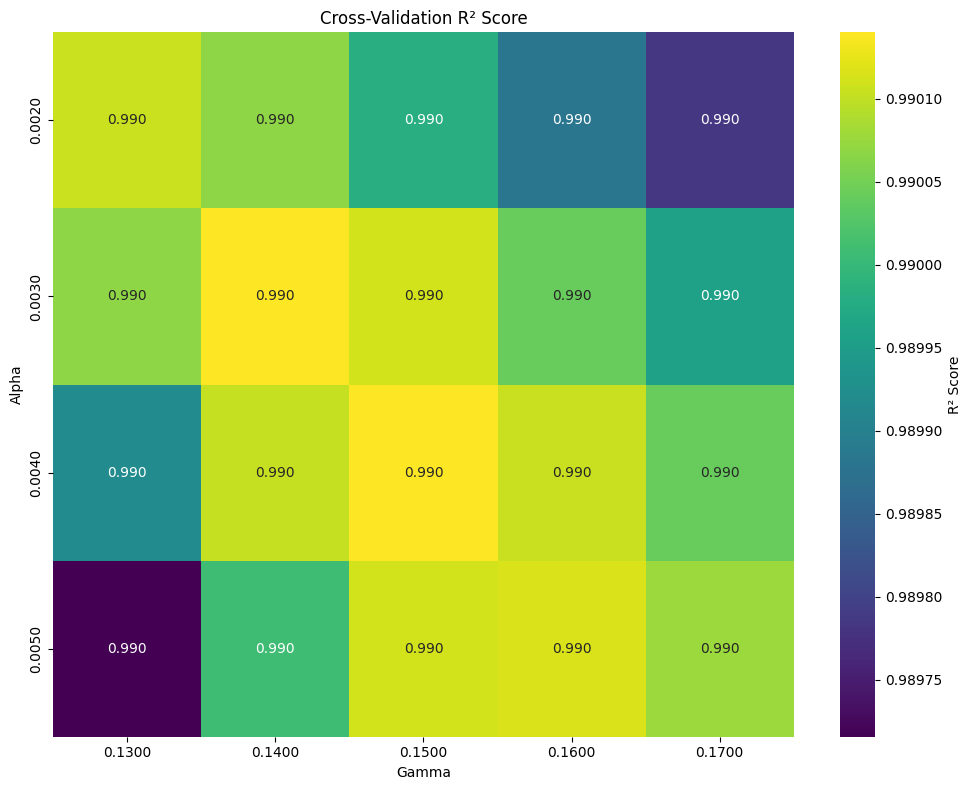

In [136]:
# Convert results to 2D array for heatmap
gamma_vals = sorted(list(set(r['gamma'] for r in results)))
alpha_vals = sorted(list(set(r['alpha'] for r in results)))

# Create heatmap data
heatmap_data = np.zeros((len(alpha_vals), len(gamma_vals)))

for i, alpha in enumerate(alpha_vals):
    for j, gamma in enumerate(gamma_vals):
        # Find corresponding mean_r2
        for r in results:
            if r['gamma'] == gamma and r['alpha'] == alpha:
                heatmap_data[i, j] = r['mean_r2']
                break

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt=".3f", 
            xticklabels=[f"{g:.4f}" for g in gamma_vals],
            yticklabels=[f"{a:.4f}" for a in alpha_vals],
            cmap="viridis",
            cbar_kws={'label': 'R² Score'})
plt.title("Cross-Validation R² Score")
plt.xlabel("Gamma")
plt.ylabel("Alpha")
plt.tight_layout()
plt.show()